In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
(LinearRegression ,
LogisticRegression ,
Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
(train_test_split ,
GridSearchCV)

### Torch specific imports

In [2]:
# essentials
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

In [4]:
# helper packages
from torchmetrics import (MeanAbsoluteError ,
R2Score)
from torchinfo import summary
from torchvision.io import read_image

In [5]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [14]:
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)   # for reproducibility
# instruct torch to use deterministic algos where possible
torch.use_deterministic_algorithms(True , warn_only=True)

Seed set to 0


In [15]:
# datasets, pretrained weights, tranformations
from torchvision.datasets import MNIST , CIFAR100
from torchvision.models import (resnet50 ,
                                ResNet50_Weights)
from torchvision.transforms import (Resize ,
                                    Normalize ,
                                    CenterCrop ,
                                    ToTensor)

In [16]:
from ISLP.torch import (SimpleDataModule ,
                        SimpleModule ,
                        ErrorTracker ,
                        rec_num_workers)

In [17]:
from ISLP.torch.imdb import (load_lookup ,
                            load_tensor ,
                            load_sparse ,
                            load_sequential)

In [18]:
from glob import glob
import json

# 10.9.1 Single Layer Network on Hitters Data

In [19]:
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]

In [20]:
model = MS(Hitters.columns.drop('Salary'), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters['Salary'].to_numpy()

In [21]:
(X_train ,
X_test ,
Y_train ,
Y_test) = train_test_split(X,
                            Y,
                            test_size=1/3,
                            random_state=1)

### Linear Models

In [22]:
# linear regression
hit_lm = LinearRegression().fit(X_train , Y_train)
Yhat_test = hit_lm.predict(X_test)
np.abs(Yhat_test - Y_test).mean()   # mae

259.71528833146317

In [23]:
# lasso
scaler = StandardScaler(with_mean=True , with_std=True)
lasso = Lasso(warm_start=True , max_iter =30000)
standard_lasso = Pipeline(steps=[('scaler', scaler),
                                 ('lasso', lasso)])

In [25]:
# using cv to select lambda
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
param_grid = {'alpha': np.exp(np.linspace(0, np.log(0.01), 100))
              * lam_max}

In [26]:
cv = KFold(10,
           shuffle=True ,
           random_state=1)
grid = GridSearchCV(lasso ,
                    param_grid ,
                    cv=cv,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train , Y_train);

In [27]:
# best lasso model
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean()  # test mae

257.23820107995016

### Specifying a Network: Classes and Inhertiance

In [28]:
# subclassing to define model
class HittersModel(nn.Module):
    def __init__(self, input_size):
        super(HittersModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size , 50),
            nn.ReLU(),
            nn.Dropout (0.4),
            nn.Linear(50, 1))
    def forward(self , x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [29]:
hit_model = HittersModel(X.shape[1])

In [30]:
# model summary
summary(hit_model ,
        input_size=X_train.shape ,
        col_names=['input_size',
                    'output_size',
                    'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [31]:
# torch typically works with 32-bit floating point numbers
# convert data to tensors
# arrange X and y into a dataset using TensorDataset
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t , Y_train_t)

In [32]:
# repeating for test data
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t , Y_test_t)

In [33]:
# number of processes to load data
max_num_workers = rec_num_workers()
max_num_workers

8

In [35]:
hit_dm = SimpleDataModule(hit_train ,
                          hit_test ,
                          batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=hit_test)

In [37]:
# .regression() indicates that squared-error loss is used
hit_module = SimpleModule.regression(hit_model ,
                                metrics={'mae':MeanAbsoluteError()})

In [38]:
# log history
hit_logger = CSVLogger('logs', name='hitters')

In [39]:
# train model
hit_trainer = Trainer(deterministic=True ,
                      max_epochs=50,
                      log_every_n_steps=5,
                      logger=hit_logger ,
                      callbacks=[ErrorTracker()])
hit_trainer.fit(hit_module , datamodule=hit_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs\hitters

  | Name  | Type         | Params
---------------------------------------
0 | model | HittersModel | 1.1 K 
1 | loss  | MSELoss      | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=50` reached.


In [40]:
# test performance
hit_trainer.test(hit_module , datamodule=hit_dm)

Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss              104098.546875
        test_mae            229.50115966796875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 104098.546875, 'test_mae': 229.50115966796875}]

In [41]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [42]:
# function to plot results
def summary_plot(results ,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                        ['black',
                        'red'],
                        [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column ,
                     label=label ,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

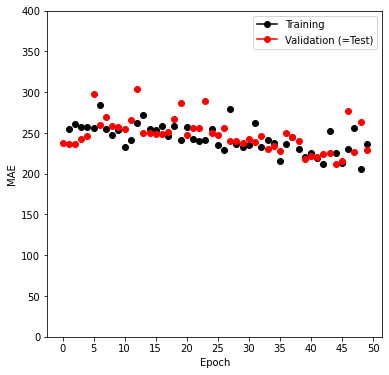

In [43]:
fig , ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(hit_results ,
                  ax,
                  col='mae',
                  ylabel='MAE',
                  valid_legend='Validation (=Test)')
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

In [44]:
hit_model.eval()   # considers model to be fitted 
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(229.5012, grad_fn=<MeanBackward0>)

### Cleanup

In [45]:
# terminate running worker processes
del(Hitters ,
    hit_model , hit_dm ,
    hit_logger ,
    hit_test , hit_train ,
    X, Y,
    X_test , X_train ,
    Y_test , Y_train ,
    X_test_t , Y_test_t ,
    hit_trainer , hit_module)

# 10.9.2 Multilayer Network on MNIST Digit Data

In [46]:
(mnist_train ,
mnist_test) = [MNIST(root='data',
                     train=train ,
                     download=True ,
                     transform=ToTensor())   # image transformations
                   for train in [True , False]]
mnist_train

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:02<00:00, 4862845.68it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|███████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 9859652.76it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 4279590.74it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 2304127.81it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [47]:
# 20% of data for validation
mnist_dm = SimpleDataModule(mnist_train ,
                            mnist_test ,
                            validation=0.2,
                            num_workers=max_num_workers ,
                            batch_size =256)

In [48]:
for idx , (X_ ,Y_) in enumerate(mnist_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


each batch has 256 images having 1 channel, and 28 x 28 pixels

In [50]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout (0.3))
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(128, 10))
    def forward(self, x):
        return self._forward(x)

In [51]:
mnist_model = MNISTModel()

In [52]:
# output size
mnist_model(X_).size()

torch.Size([256, 10])

In [53]:
summary(mnist_model ,
        input_data=X_,
        col_names=['input_size',
                    'output_size',
                    'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

In [55]:
mnist_module = SimpleModule.classification(mnist_model,
                                          num_classes=10)
mnist_logger = CSVLogger('logs', name='MNIST')

In [56]:
mnist_trainer = Trainer(deterministic=True ,
                        max_epochs=30,
                        logger=mnist_logger ,
                        callbacks=[ErrorTracker()])
mnist_trainer.fit(mnist_module ,
                datamodule=mnist_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs\MNIST

  | Name  | Type             | Params
-------------------------------------------
0 | model | MNISTModel       | 235 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.


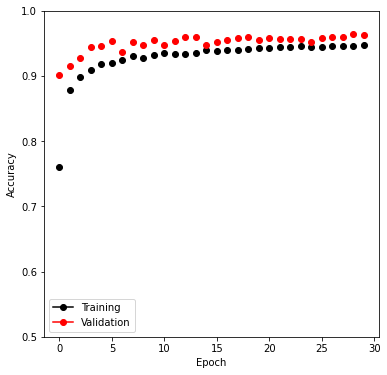

In [57]:
mnist_results = pd.read_csv(mnist_logger.experiment.
                            metrics_file_path)
fig , ax = subplots(1, 1, figsize=(6, 6))
summary_plot(mnist_results ,
            ax,
            col='accuracy',
            ylabel='Accuracy')
ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int));

In [58]:
mnist_trainer.test(mnist_module ,
                    datamodule=mnist_dm)

Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9643999934196472
        test_loss           0.1472465842962265
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.1472465842962265, 'test_accuracy': 0.9643999934196472}]

In [62]:
# multiclass logistic regression (no hidden layers)
class MNIST_MLR(nn.Module):
    def __init__(self):
        super(MNIST_MLR, self).__init__()
        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784, 10))
    def forward(self , x):
        return self.linear(x)

mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model,
                                        num_classes=10)
mlr_logger = CSVLogger('logs', name='MNIST_MLR')

In [63]:
mlr_trainer = Trainer(deterministic=True ,
                        max_epochs=30,
                        callbacks=[ErrorTracker()])
mlr_trainer.fit(mlr_module , datamodule=mnist_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\applications\envs\genenv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: D:\Amruthaa\Exploration\ISLP\Chapter_10\lightning_logs

  | Name  | Type             | Params
-------------------------------------------
0 | model | MNIST_MLR        | 7.9 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
7.9 K     Trainable params
0         Non-t

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.


In [64]:
mlr_trainer.test(mlr_module ,
                datamodule=mnist_dm)

Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9142000079154968
        test_loss           0.35298365354537964
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.35298365354537964, 'test_accuracy': 0.9142000079154968}]

In [65]:
del(mnist_test ,
    mnist_train ,
    mnist_model ,
    mnist_dm ,
    mnist_trainer ,
    mnist_module ,
    mnist_results ,
    mlr_model ,
    mlr_module ,
    mlr_trainer)

# 10.9.3 Convolutional Neural Networks

In [66]:
(cifar_train ,
cifar_test) = [CIFAR100(root="data",
                        train=train ,
                        download=True)
                    for train in [True , False]]

100%|███████████████████████████████████████████████████████████████| 169001437/169001437 [00:33<00:00, 5087198.58it/s]


Extracting data\cifar-100-python.tar.gz to data
Files already downloaded and verified


In [67]:
transform = ToTensor()
cifar_train_X = torch.stack([transform(x) for x in
                            cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in
                            cifar_test.data])
cifar_train = TensorDataset(cifar_train_X ,
                            torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X ,
                            torch.tensor(cifar_test.targets))

In [68]:
cifar_dm = SimpleDataModule(cifar_train ,
                            cifar_test ,
                            validation=0.2,
                            num_workers=max_num_workers ,
                            batch_size =128)

In [69]:
for idx , (X_ ,Y_) in enumerate(cifar_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])
X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])


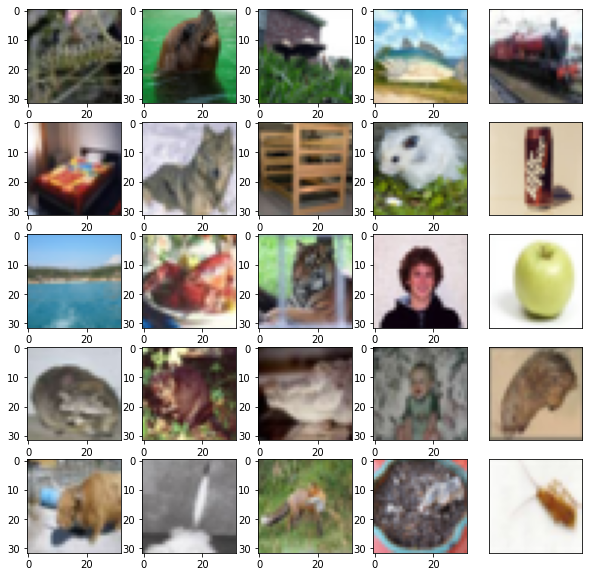

In [70]:
fig , axes = subplots(5, 5, figsize=(10,10))
rng = np.random.default_rng(4)
indices = rng.choice(np.arange(len(cifar_train)), 25,
                        replace=False).reshape((5,5))
for i in range(5):
    for j in range(5):
        idx = indices[i,j]
        axes[i,j].imshow(np.transpose(cifar_train[idx][0],
                                        [1,2,0]),
                                        interpolation=None)
    axes[i,j].set_xticks ([])
    axes[i,j].set_yticks ([])

In [72]:
# use multiple building blocks for final model
class BuildingBlock(nn.Module):
    def __init__(self ,
                in_channels ,
                out_channels):
        super(BuildingBlock , self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels ,
                            out_channels=out_channels ,
                            kernel_size=(3,3),
                            padding='same')
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
    
    def forward(self , x):
        return self.pool(self.activation(self.conv(x)))

In [73]:
class CIFARModel(nn.Module):
    def __init__(self):
        super(CIFARModel , self).__init__()
        sizes = [(3,32),
                (32,64),
                (64,128),
                (128,256)]
        self.conv = nn.Sequential(*[BuildingBlock(in_ , out_)
                                    for in_ , out_ in sizes])
        self.output = nn.Sequential(nn.Dropout (0.5),
                                    nn.Linear(2*2*256, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 100))
    def forward(self , x):
        val = self.conv(x)
        val = torch.flatten(val , start_dim=1)
        return self.output(val)

In [75]:
cifar_model = CIFARModel()
summary(cifar_model,
        input_data=X_,
        col_names=['input_size',
                    'output_size',
                    'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CIFARModel                               [128, 3, 32, 32]          [128, 100]                --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 256, 2, 2]          --
│    └─BuildingBlock: 2-1                [128, 3, 32, 32]          [128, 32, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    │    └─ReLU: 3-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
│    │    └─MaxPool2d: 3-3               [128, 32, 32, 32]         [128, 32, 16, 16]         --
│    └─BuildingBlock: 2-2                [128, 32, 16, 16]         [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    │    └─ReLU: 3-5                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─MaxPool2d: 3-6    

In [77]:
# custom optimizer
cifar_optimizer = RMSprop(cifar_model.parameters(), lr=0.001)
cifar_module = SimpleModule.classification(cifar_model ,
                                          optimizer=cifar_optimizer,
                                          num_classes=100)
cifar_logger = CSVLogger('logs', name='CIFAR100')

In [78]:
cifar_trainer = Trainer(deterministic=True ,
                        max_epochs=30,
                        logger=cifar_logger ,
                        callbacks=[ErrorTracker()])
cifar_trainer.fit(cifar_module ,
                datamodule=cifar_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs\CIFAR100

  | Name  | Type             | Params
-------------------------------------------
0 | model | CIFARModel       | 964 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:04<…

Validation: |                                                                                    | 0/? [00:01<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.


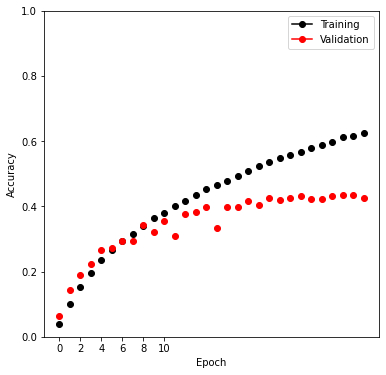

In [79]:
log_path = cifar_logger.experiment.metrics_file_path
cifar_results = pd.read_csv(log_path)
fig , ax = subplots(1, 1, figsize=(6, 6))
summary_plot(cifar_results ,
            ax,
            col='accuracy',
            ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 10, 6).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1]);

In [80]:
# test evaluation
cifar_trainer.test(cifar_module ,
                    datamodule=cifar_dm)

Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.43220001459121704
        test_loss            2.332275629043579
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.332275629043579, 'test_accuracy': 0.43220001459121704}]

### Hardware Acceleration

In [ ]:
try:
    for name , metric in cifar_module.metrics.items():
        cifar_module.metrics[name] = metric.to('mps')
    cifar_trainer_mps = Trainer(accelerator='mps',
                                deterministic=True ,
                                max_epochs =30)
    cifar_trainer_mps.fit(cifar_module ,
                        datamodule=cifar_dm)
    cifar_trainer_mps.test(cifar_module ,
                        datamodule=cifar_dm)
except:
    pass

# 10.9.4 Using Pretrained CNN Models

In [82]:
# image preprocessing
resize = Resize ((232,232))
crop = CenterCrop (224)
normalize = Normalize ([0.485,0.456,0.406],
                        [0.229 ,0.224 ,0.225])
imgfiles = sorted([f for f in glob('book_images/*')])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255)
                    for f in imgfiles])
imgs = normalize(imgs)
imgs.size()

torch.Size([5, 3, 224, 224])

In [83]:
# set up network with weights
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
summary(resnet_model ,
        input_data=imgs ,
        col_names=['input_size',
                    'output_size',
                    'num_params'])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Amruthaa/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:18<00:00, 5.40MB/s]


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [5, 3, 224, 224]          [5, 1000]                 --
├─Conv2d: 1-1                            [5, 3, 224, 224]          [5, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [5, 64, 112, 112]         [5, 64, 112, 112]         128
├─ReLU: 1-3                              [5, 64, 112, 112]         [5, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [5, 64, 112, 112]         [5, 64, 56, 56]           --
├─Sequential: 1-5                        [5, 64, 56, 56]           [5, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [5, 64, 56, 56]           [5, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [5, 64, 56, 56]           [5, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [5, 64, 56, 56]           [5, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

In [84]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [85]:
img_preds = resnet_model(imgs)

In [86]:
# detach converts tensor to ndarray
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:,None]

In [88]:
# getting class labels
labs = json.load(open('imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in
                            labs.items()],
                            columns=['idx', 'label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()

In [89]:
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:3]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))

Image: book_images\Cape_Weaver.jpg
       label      prob
0    jacamar  0.278434
1  bee_eater  0.047995
2     bulbul  0.039503
Image: book_images\Hawk_Fountain.jpg
            label      prob
0  great_grey_owl  0.281775
1            kite  0.042421
2        fountain  0.029358
Image: book_images\Hawk_cropped.jpg
    label      prob
0    kite  0.297036
1     jay  0.125637
2  magpie  0.015668
Image: book_images\Lhasa_Apso.jpg
             label      prob
0            Lhasa  0.150391
1         Shih-Tzu  0.129453
2  Tibetan_terrier  0.103608
Image: book_images\Sleeping_Cat.jpg
       label      prob
0      tabby  0.172463
1  tiger_cat  0.110840
2    doormat  0.089069


In [90]:
del(cifar_test ,
    cifar_train ,
    cifar_dm ,
    cifar_module ,
    cifar_logger ,
    cifar_optimizer ,
    cifar_trainer)

# 10.9.5 IMDB Document Classification

In [91]:
(imdb_seq_train ,
imdb_seq_test) = load_sequential(root='data/IMDB')
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
sample_review = padded_sample[padded_sample > 0][:12]  # removing padding
sample_review[:12]   # 1st 12 words

Retrieving "IMDB_S_train.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_S_test.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_Y_test.npy" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_Y_train.npy" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468])

In [92]:
# finding words
lookup = load_lookup(root='data/IMDB')
' '.join(lookup[i] for i in sample_review)

Retrieving "IMDB_word_index.pkl" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


"<START> this film was just brilliant casting location scenery story direction everyone's"

In [93]:
# using data with binary features (load_tensor)
max_num_workers =10
(imdb_train ,
imdb_test) = load_tensor(root='data/IMDB')
imdb_dm = SimpleDataModule(imdb_train ,
                        imdb_test ,
                        validation=2000,
                        num_workers=min(6, max_num_workers),
                        batch_size =512)

Retrieving "IMDB_X_test.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_X_train.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


In [94]:
# 2 layer model
class IMDBModel(nn.Module):
    def __init__(self , input_size):
        super(IMDBModel , self).__init__()
        self.dense1 = nn.Linear(input_size , 16)
        self.activation = nn.ReLU()
        self.dense2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)
    def forward(self , x):
        val = x
        for _map in [self.dense1 ,
                    self.activation ,
                    self.dense2 ,
                    self.activation ,
                    self.output]:
            val = _map(val)
        return torch.flatten(val)

In [95]:
imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model ,
        input_size=imdb_test.tensors[0].size(),
        col_names=['input_size',
                    'output_size',
                    'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

In [96]:
# binary classification
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(
                        imdb_model ,
                        optimizer=imdb_optimizer)

In [97]:
# fitting model
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True ,
                    max_epochs=30,
                    logger=imdb_logger ,
                    callbacks=[ErrorTracker()])
imdb_trainer.fit(imdb_module ,
                datamodule=imdb_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs\IMDB

  | Name  | Type              | Params
--------------------------------------------
0 | model | IMDBModel         | 160 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

D:\applications\envs\genenv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:02<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.


In [98]:
# test performance
test_results = imdb_trainer.test(imdb_module , datamodule=imdb_dm)
test_results

Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8478000164031982
        test_loss           1.1705756187438965
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.1705756187438965, 'test_accuracy': 0.8478000164031982}]

### Comparison to Lasso

In [99]:
# need a sparse representation for use with sklearn
((X_train , Y_train),
(X_valid , Y_valid),
(X_test , Y_test)) = load_sparse(validation=2000,
                                random_state=0,
                                root='data/IMDB')

Retrieving "IMDB_X_test.npz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_X_train.npz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


In [100]:
# 50 values for lambda
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1),
                                        np.log(1e-4), 50))

In [101]:
# use 1/lam_max in logistic regression
logit = LogisticRegression(penalty='l1',
                            C=1/lam_max ,
                            solver='liblinear',
                            warm_start=True ,
                            fit_intercept=True)

In [102]:
coefs = []
intercepts = []

for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train , Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)

In [103]:
# removing extra dimension
coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)

In [105]:
%%capture
fig , axes = subplots(1, 2, figsize=(16, 8), sharey=True)
for ((X_, Y_),
    data_ ,
    color) in zip([(X_train , Y_train),
                (X_valid , Y_valid),
                (X_test , Y_test)],
                ['Training', 'Validation', 'Test'],
                ['black', 'red', 'blue']):
    linpred_ = X_ * coefs.T + intercepts[None ,:]
    label_ = np.array(linpred_ > 0)
    accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
    axes[0].plot(-np.log(lam_val / X_train.shape[0]),
                accuracy_ ,
                '.--',
                color=color ,
                markersize=13,
                linewidth=2,
                label=data_)
axes[0].legend()
axes[0]. set_xlabel(r'$-\log(\lambda)$', fontsize=20)
axes[0]. set_ylabel('Accuracy', fontsize=20)

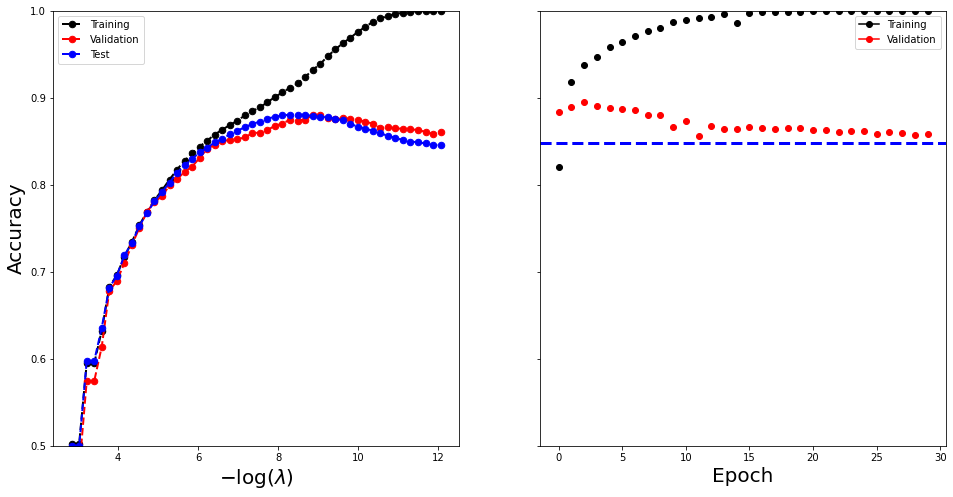

In [106]:
imdb_results = pd.read_csv(imdb_logger.experiment.metrics_file_path)
summary_plot(imdb_results ,
            axes[1],
            col='accuracy',
            ylabel='Accuracy')
axes[1]. set_xticks(np.linspace(0, 30, 7).astype(int))
axes[1]. set_ylabel('Accuracy', fontsize=20)
axes[1]. set_xlabel('Epoch', fontsize=20)
axes[1]. set_ylim([0.5, 1]);
axes[1].axhline(test_results [0]['test_accuracy'],
                color='blue',
                linestyle='--',
                linewidth=3)
fig

In [107]:
del(imdb_model ,
    imdb_trainer ,
    imdb_logger ,
    imdb_dm ,
    imdb_train ,
    imdb_test)

# 10.9.6 Recurrent Neural Networks

### Sequential Models for Document Classification

In [108]:
imdb_seq_dm = SimpleDataModule(imdb_seq_train ,
                            imdb_seq_test ,
                            validation=2000,
                            batch_size=300,
                            num_workers=min(6, max_num_workers)
                              )

In [109]:
class LSTMModel(nn.Module):
    def __init__(self , input_size):
        super(LSTMModel , self).__init__()
        self.embedding = nn.Embedding(input_size , 32)
        self.lstm = nn.LSTM(input_size=32,
                            hidden_size=32,
                            batch_first=True)
        self.dense = nn.Linear(32, 1)
    def forward(self , x):
        val , (h_n , c_n) = self.lstm(self.embedding(x))
        return torch.flatten(self.dense(val[:,-1]))

In [110]:
lstm_model = LSTMModel(X_test.shape[-1])
summary(lstm_model ,
        input_data=imdb_seq_train.tensors [0][:10],
        col_names=['input_size',
                    'output_size',
                    'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [10, 500]                 [10]                      --
├─Embedding: 1-1                         [10, 500]                 [10, 500, 32]             320,096
├─LSTM: 1-2                              [10, 500, 32]             [10, 500, 32]             8,448
├─Linear: 1-3                            [10, 32]                  [10, 1]                   33
Total params: 328,577
Trainable params: 328,577
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 45.44
Input size (MB): 50.00
Forward/backward pass size (MB): 2.56
Params size (MB): 1.31
Estimated Total Size (MB): 53.87

In [111]:
lstm_module = SimpleModule.binary_classification(lstm_model)
lstm_logger = CSVLogger('logs', name='IMDB_LSTM')

In [112]:
lstm_trainer = Trainer(deterministic=True ,
                        max_epochs=20,
                        logger=lstm_logger ,
                        callbacks=[ErrorTracker()])
lstm_trainer.fit(lstm_module ,
                datamodule=imdb_seq_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs\IMDB_LSTM

  | Name  | Type              | Params
--------------------------------------------
0 | model | LSTMModel         | 328 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.314     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:01<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:01<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.


In [113]:
# test results
lstm_trainer.test(lstm_module , datamodule=imdb_seq_dm)

Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8367199897766113
        test_loss            0.763116717338562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.763116717338562, 'test_accuracy': 0.8367199897766113}]

(0.5, 1.0)

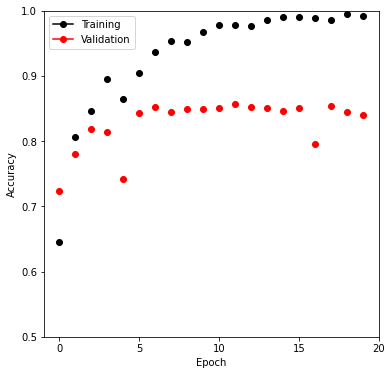

In [114]:
lstm_results = pd.read_csv(lstm_logger.experiment.metrics_file_path)
fig , ax = subplots(1, 1, figsize=(6, 6))
summary_plot(lstm_results ,
            ax,
            col='accuracy',
            ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 20, 5).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])

In [115]:
del(lstm_model ,
    lstm_trainer ,
    lstm_logger ,
    imdb_seq_dm ,
    imdb_seq_train ,
    imdb_seq_test)

### Time Series Prediction

In [116]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(
                    with_mean=True ,
                    with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns ,
                 index=NYSE.index)

In [117]:
# lagged data
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col , lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

In [118]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

In [120]:
M = LinearRegression()
M.fit(X[train], Y[train])
M.score(X[~train], Y[~train])

0.41289129385625223

In [121]:
X_day = pd.merge(X,
    pd.get_dummies(NYSE['day_of_week']),
    on='date')

In [123]:
M.fit(X_day[train], Y[train])
M.score(X_day[~train], Y[~train])

0.4595563133053274

In [124]:
ordered_cols = []
for lag in range(5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col , lag))
X = X.reindex(columns=ordered_cols)
X.columns

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

In [125]:
X_rnn = X.to_numpy().reshape((-1,5,3))
X_rnn.shape

(6046, 5, 3)

In [126]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel , self).__init__()
        self.rnn = nn.RNN(3,
                        12,
                        batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout (0.1)
    def forward(self , x):
        val , h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:,-1]))
        return torch.flatten(val)
nyse_model = NYSEModel()

In [128]:
datasets = []
for mask in [train , ~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t , Y_t))
nyse_train , nyse_test = datasets

In [129]:
summary(nyse_model ,
    input_data=X_rnn_t ,
    col_names=['input_size',
                'output_size',
                'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 3]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 3]              [1770, 5, 12]             204
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 217
Trainable params: 217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.83
Input size (MB): 0.11
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 0.97

In [130]:
nyse_dm = SimpleDataModule(nyse_train ,
                        nyse_test ,
                        num_workers=min(4, max_num_workers),
                        validation=nyse_test ,
                        batch_size =64)

In [131]:
for idx , (x, y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(), out.size())
    if idx >= 2:
        break

torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


In [132]:
nyse_optimizer = RMSprop(nyse_model.parameters(),
                        lr=0.001)
nyse_module = SimpleModule.regression(nyse_model ,
                                    optimizer=nyse_optimizer ,
                                    metrics={'r2':R2Score()})

In [133]:
nyse_trainer = Trainer(deterministic=True ,
                        max_epochs=200,
                        callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module ,
                datamodule=nyse_dm)
nyse_trainer.test(nyse_module ,
                datamodule=nyse_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NYSEModel | 217   
1 | loss  | MSELoss   | 0     
------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=200` reached.


Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6246964335441589
         test_r2             0.407132625579834
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6246964335441589, 'test_r2': 0.407132625579834}]

In [135]:
datasets = []
for mask in [train , ~train]:
    X_day_t = torch.tensor(
                np.asarray(X_day[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t , Y_t))
day_train , day_test = datasets

In [136]:
day_dm = SimpleDataModule(day_train ,
                        day_test ,
                        num_workers=min(4, max_num_workers),
                        validation=day_test ,
                        batch_size =64)

In [137]:
class NonLinearARModel(nn.Module):
    def __init__(self):
        super(NonLinearARModel , self).__init__()
        self._forward = nn.Sequential(nn.Flatten(),
                                      nn.Linear(20, 32),
                                      nn.ReLU(),
                                      nn.Dropout (0.5),
                                      nn.Linear(32, 1))
    def forward(self , x):
        return torch.flatten(self._forward(x))

In [138]:
nl_model = NonLinearARModel()
nl_optimizer = RMSprop(nl_model.parameters(),
                        lr=0.001)
nl_module = SimpleModule.regression(nl_model ,
                                    optimizer=nl_optimizer ,
                                    metrics={'r2':R2Score()})

In [139]:
nl_trainer = Trainer(deterministic=True ,
                    max_epochs=20,
                    callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module , datamodule=day_dm)
nl_trainer.test(nl_module , datamodule=day_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | NonLinearARModel | 705   
1 | loss  | MSELoss          | 0     
-------------------------------------------
705       Trainable params
0         Non-trainable params
705       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5614730715751648
         test_r2            0.46713465452194214
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5614730715751648, 'test_r2': 0.46713465452194214}]